### DiBS joint inference of $p(G, \Theta | D)$ for linear/nonlinear Gaussian Bayes nets

DiBS translates the task of inferring the posterior over Bayesian networks into an inference problem over the continuous latent variable $Z$. This is achieved by modeling the directed acyclic graph $G$ of the Bayesian network using the generative model $p(G | Z)$. The prior $p(Z)$ enforces the acyclicity of $G$.
Ultimately, this allows us to infer $p(G, \Theta | D)$ (and $p(G | D)$) using off-the-shelf inference methods such as Stein Variational gradient descent (SVGD) (Liu and Wang, 2016).

In [1]:
import jax
import jax.random as random

key = random.PRNGKey(123)
print(f"JAX backend: {jax.default_backend()}")

2024-06-07 14:45:06.297164: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


JAX backend: gpu


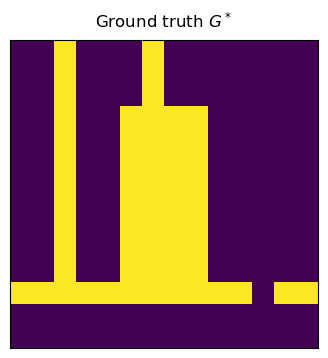

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import logit, expit
from dibs.utils import visualize_ground_truth

def rescale_beta(x, lower=-3, upper=3):
    res = (x - lower) / (upper - lower)
    return((res * (len(x) - 1) + .5) / len(x))


def standardize(x):
    return( (x - np.mean(x))/np.std(x) )

df = pd.read_csv("data/s1-data.csv")
# df = df.apply(standardize)

df = df.apply(rescale_beta).apply(logit).apply(standardize)


train, test = train_test_split(df.to_numpy(), test_size=0.2, random_state = 123)

bl = pd.read_csv("data/theory-bl.csv")
bl = bl[df.columns.to_list()].to_numpy()
visualize_ground_truth(bl)




In [7]:
from dibs.models.graph import ErdosReniDAGDistribution, ScaleFreeDAGDistribution
from dibs.models.linearGaussian import LinearGaussian
from dibs.models.nonlinearGaussian import DenseNonlinearGaussian
from dibs.metrics import elwise_acyclic_constr_nograd, tree_select, tree_mul
from scipy.special import logsumexp

import jax.numpy as jnp

class ScaleFreeDAGDistributionBlacklist:
    """
    Randomly-oriented scale-free random graph with power-law degree distribution.
    The pmf is defined as

    :math:`p(G) \\propto \\prod_j (1 + \\text{deg}(j))^{-3}`

    where :math:`\\text{deg}(j)` denotes the in-degree of node :math:`j`

    Args:
        n_vars (int): number of variables in DAG
        n_edges_per_node (int): number of edges sampled per variable

    """

    def __init__(self, n_vars, verbose=False, n_edges_per_node=2, blackadj = None):
        self.n_vars = n_vars
        self.n_edges_per_node = n_edges_per_node
        self.verbose = verbose

        if blackadj is None:
            self.blackadj = jnp.zeros((n_vars, n_vars))
        else:
            self.blackadj = blackadj


    def unnormalized_log_prob_soft(self, *, soft_g):
        """
        Computes :math:`\\log p(G)` up the normalization constant
        where :math:`G` is the matrix of edge probabilities

        Args:
            soft_g (ndarray): graph adjacency matrix, where entries
                may be probabilities and not necessarily 0 or 1

        Returns:
            unnormalized log probability corresponding to edge probabilities in :math:`G`

        """
        soft_indegree = soft_g.sum(0)
        penalty = 1e5 * (soft_g * self.blackadj).sum() # conceptually, big penalty x sum(soft_g * blackadj)
        return jnp.sum(-3 * jnp.log(1 + soft_indegree)) - penalty



In [8]:
N_vars = df.shape[1]
graph_model = ScaleFreeDAGDistributionBlacklist(N_vars, n_edges_per_node = 4, blackadj = bl)

## choose model type ...
# likelihood_model = LinearGaussian(n_vars = N_vars)
likelihood_model = DenseNonlinearGaussian(n_vars = N_vars, hidden_layers = (5,))

### DiBS with SVGD

Infer $p(G, \Theta | D)$ under the prior and conditional distributions defined by the model.
The below visualization shows the *matrix of edge probabilities* $G_\alpha(Z^{(k)})$ implied by each transported latent particle (i.e., sample) $Z^{(k)}$ during the iterations of SVGD with DiBS. Refer to the paper for further details.

To explicitly perform posterior inference of $p(G | D)$ using a closed-form marginal likelihood $p(D | G)$, use the separate, analogous class `MarginalDiBS` as demonstrated in the example notebook `dibs_marginal.ipynb`.



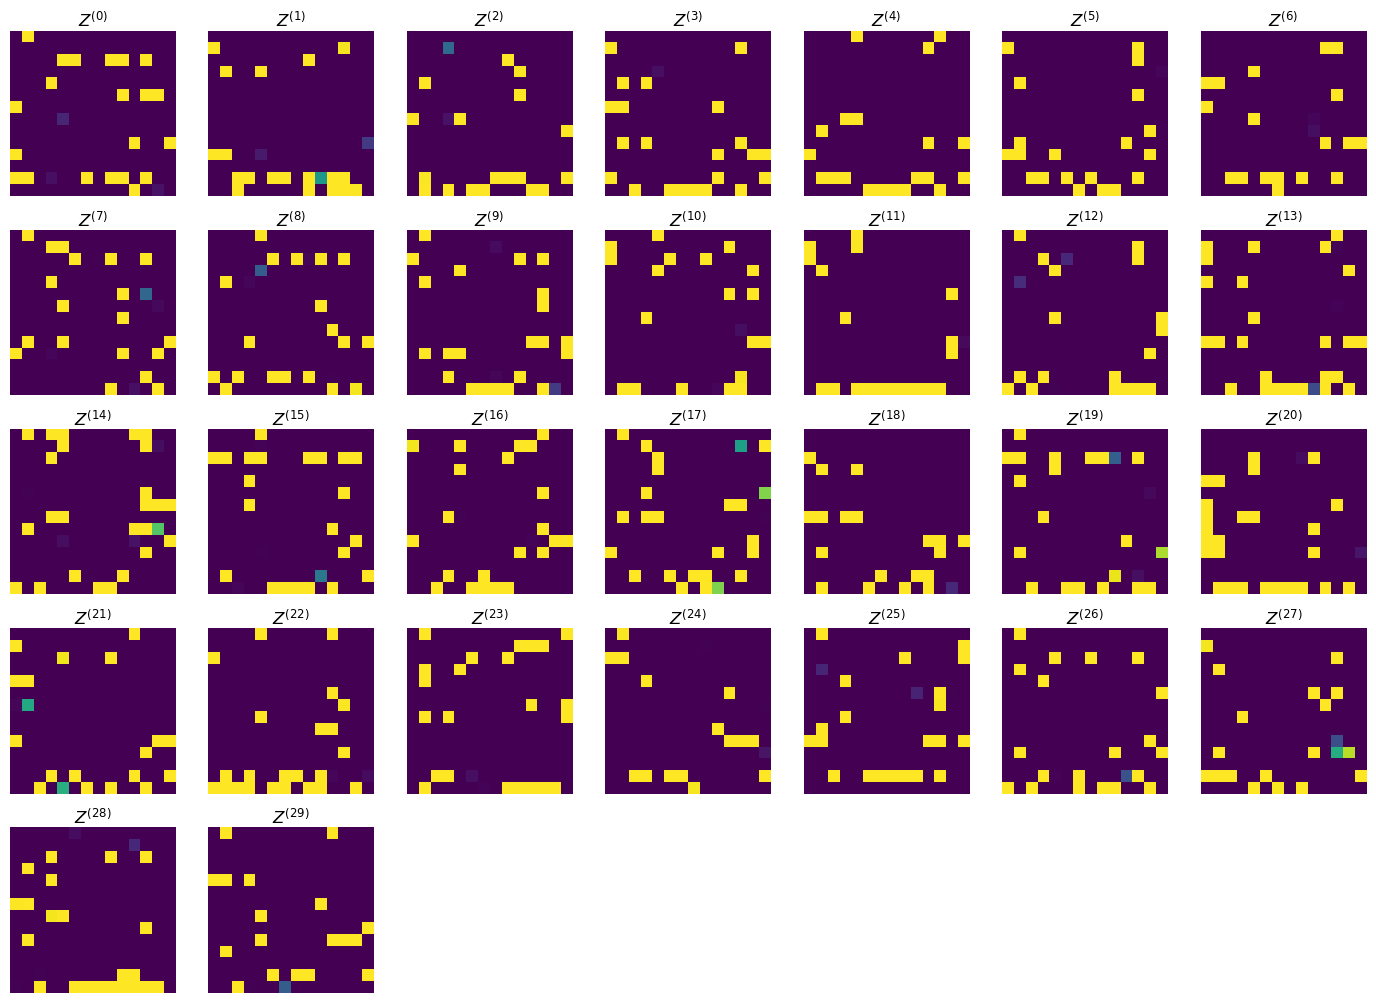

iteration   3000 | alpha  150.0 | beta 3000.0 | #cyclic   5


In [9]:
from dibs.inference import JointDiBS

DIBS = JointDiBS(x=train, interv_mask=None, graph_model=graph_model, likelihood_model=likelihood_model)
key, subk = random.split(key)
gs, thetas = DIBS.sample(key=subk, n_particles=30, steps=3000, callback_every=20, callback=DIBS.visualize_callback())

### Evaluate on held-out data

Form the empirical (i.e., weighted by counts) and mixture distributions (i.e., weighted by unnormalized posterior probabilities, denoted DiBS+).

In [10]:
dibs_empirical = DIBS.get_empirical(gs, thetas)
dibs_mixture = DIBS.get_mixture(gs, thetas)

Compute some evaluation metrics.

In [11]:
from dibs.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

for descr, dist in [('DiBS ', dibs_empirical), ('DiBS+', dibs_mixture)]:
    
    # eshd = expected_shd(dist=dist, g=data.g)        
    # auroc = threshold_metrics(dist=dist, g=data.g)['roc_auc']
    negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=DIBS.eltwise_log_likelihood_observ, x=test)
    
    print(f'{descr} | neg. LL {negll:5.2f}')
    

DiBS  | neg. LL 12395.82
DiBS+ | neg. LL 11937.43


In [12]:
# compute DIBS+ edge posterior probs
res = (np.exp(dibs_mixture.logp)[:, np.newaxis, np.newaxis] * dibs_mixture.g) * dibs_mixture.logp.shape[0]
np.sum(np.mean(res, 0) > .90)


Array(20, dtype=int32)

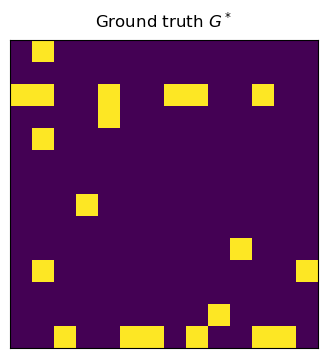

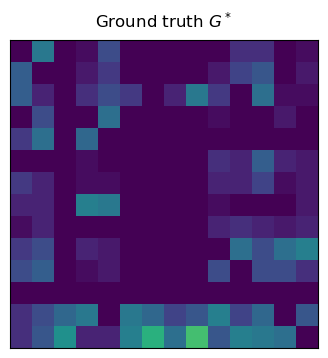

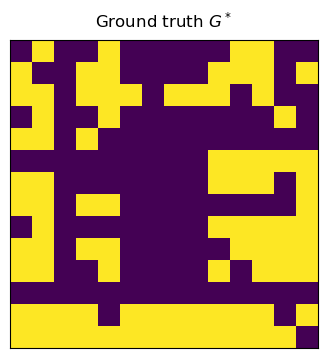

In [13]:
visualize_ground_truth(np.mean(res, 0))

visualize_ground_truth(np.mean(dibs_empirical.g, 0))

visualize_ground_truth(np.mean(dibs_empirical.g, 0) > .05)

In [16]:
likelihood_model.nn_forward(thetas, test).shape

(226, 30, 14, 30, 14)